In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install opencv-python pillow scikit-learn pandas matplotlib tqdm kaggle --quiet

import torch
print("✅ GPU available:", torch.cuda.is_available())


✅ GPU available: True


In [2]:
import os

# Move your Kaggle key to correct folder
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ahmedismaiil/skin-issues-version-2-dataset-balanced

# Unzip dataset
!unzip -q skin-issues-version-2-dataset-balanced.zip -d skin_issues_v2
!ls skin_issues_v2


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open skin-issues-version-2-dataset-balanced.zip, skin-issues-version-2-dataset-balanced.zip.zip or skin-issues-version-2-dataset-bala

In [3]:
import os

# ✅ Move your Kaggle key file correctly
os.makedirs('/root/.kaggle', exist_ok=True)
!mv "kaggle (2).json" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# ✅ Download the dataset
!kaggle datasets download -d ahmedismaiil/skin-issues-version-2-dataset-balanced

# ✅ Unzip the dataset
!unzip -q skin-issues-version-2-dataset-balanced.zip -d skin_issues_v2
!ls skin_issues_v2


Dataset URL: https://www.kaggle.com/datasets/ahmedismaiil/skin-issues-version-2-dataset-balanced
License(s): unknown
 96% 392M/410M [00:00<00:00, 512MB/s]
100% 410M/410M [00:00<00:00, 564MB/s]
'Skin v2'


In [4]:
import os

data_root = "skin_issues_v2/Skin v2"

print("📁 Subfolders inside dataset:", os.listdir(data_root))
for folder in os.listdir(data_root):
    path = os.path.join(data_root, folder)
    if os.path.isdir(path):
        print(f"{folder}: {len(os.listdir(path))} images")


📁 Subfolders inside dataset: ['pores', 'blackheades', 'acne', 'wrinkles', 'dark spots']
pores: 1632 images
blackheades: 1970 images
acne: 2060 images
wrinkles: 1982 images
dark spots: 2126 images


In [5]:
import glob, shutil, random, os

base_dir = "skin_issues_v2/Skin v2"
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)

for c in os.listdir(base_dir):
    src = os.path.join(base_dir, c)
    if os.path.isdir(src):
        imgs = glob.glob(f"{src}/*")
        random.shuffle(imgs)
        split = int(0.8 * len(imgs))
        os.makedirs(f"data/train/{c}", exist_ok=True)
        os.makedirs(f"data/val/{c}", exist_ok=True)
        for i, img in enumerate(imgs):
            dst = f"data/train/{c}" if i < split else f"data/val/{c}"
            shutil.copy(img, dst)

print("✅ Train/Validation split complete!")


✅ Train/Validation split complete!


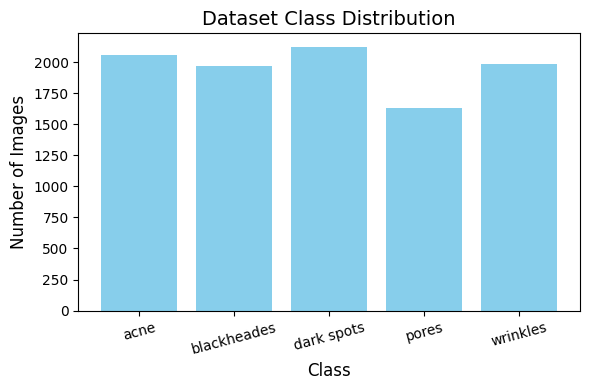

In [12]:
# ✅ Dataset Class Distribution Visualization
import matplotlib.pyplot as plt
import os

data_root = "skin_issues_v2/Skin v2"
classes = sorted(os.listdir(data_root))
counts = [len(os.listdir(os.path.join(data_root, c))) for c in classes]

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color="skyblue")
plt.title("Dataset Class Distribution", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [13]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# ✅ Define image transformations
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Custom dataset class
class SkinDataset(Dataset):
    def __init__(self, folder, tfms):
        from glob import glob
        self.paths = glob(folder + '/*/*')
        self.tfms = tfms
        self.classes = sorted(os.listdir(folder))
        self.label2idx = {c:i for i,c in enumerate(self.classes)}
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        img = Image.open(p).convert('RGB')
        label = self.label2idx[p.split('/')[-2]]
        return self.tfms(img), label


In [14]:
train_ds = SkinDataset("data/train", train_tfms)
val_ds   = SkinDataset("data/val", val_tfms)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=16)

print("✅ Data ready for model training")
print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds), "| Validation samples:", len(val_ds))


✅ Data ready for model training
Classes: ['acne', 'blackheades', 'dark spots', 'pores', 'wrinkles']
Train samples: 7814 | Validation samples: 1956


In [15]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("🧠 Using device:", device)

# ✅ Load pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_ds.classes))
model = model.to(device)

# ✅ Optimizer and loss function
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

# ✅ Train for 3 epochs (you can increase to 5–10 for higher accuracy)
for epoch in range(3):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for x, y in tqdm(train_dl):
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}: ✅ Train Accuracy = {acc:.3f}, Avg Loss = {running_loss/len(train_dl):.4f}")

# ✅ Save the trained model
torch.save(model.state_dict(), "cosmetic_skin_model.pt")
print("💾 Model saved as cosmetic_skin_model.pt")


🧠 Using device: cuda


100%|██████████| 489/489 [01:49<00:00,  4.47it/s]


Epoch 1: ✅ Train Accuracy = 0.897, Avg Loss = 0.3150


100%|██████████| 489/489 [01:45<00:00,  4.61it/s]


Epoch 2: ✅ Train Accuracy = 0.960, Avg Loss = 0.1235


100%|██████████| 489/489 [01:43<00:00,  4.71it/s]

Epoch 3: ✅ Train Accuracy = 0.968, Avg Loss = 0.0925
💾 Model saved as cosmetic_skin_model.pt


📊 Classification Report:

              precision    recall  f1-score   support

        acne       0.97      0.98      0.97       412
 blackheades       0.96      0.94      0.95       394
  dark spots       0.98      0.97      0.97       426
       pores       0.99      1.00      1.00       327
    wrinkles       0.98      0.99      0.99       397

    accuracy                           0.98      1956
   macro avg       0.98      0.98      0.98      1956
weighted avg       0.98      0.98      0.98      1956



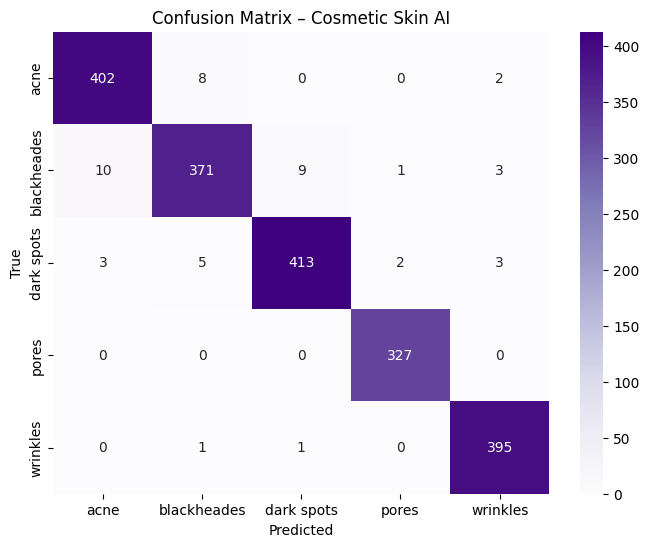

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Set the model to evaluation mode
model.eval()
preds, labels = [], []

# ✅ Collect predictions and true labels
with torch.no_grad():
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds += out.argmax(1).cpu().tolist()
        labels += y.cpu().tolist()

# ✅ Print the classification report
print("📊 Classification Report:\n")
print(classification_report(labels, preds, target_names=train_ds.classes))

# ✅ Plot the confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes,
            cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Cosmetic Skin AI")
plt.show()


In [17]:
#  AI Skin Coach – Cosmetic Guidance System
from PIL import Image
import matplotlib.pyplot as plt
import torch

# ✅ Skincare advice dictionary
def skincare_advice(pred_label):
    advice = {
        "acne": """• Use a gentle cleanser twice daily.
• Avoid touching your face frequently.
• Apply non-comedogenic moisturizer and light sunscreen daily.""",

        "blackheads": """• Exfoliate 2–3 times per week using salicylic acid or BHA products.
• Use clay or charcoal masks to keep pores clean.
• Avoid heavy oil-based creams or cosmetics.""",

        "dark spots": """• Apply sunscreen every day to prevent further pigmentation.
• Use brightening serums with vitamin C or niacinamide.
• Stay hydrated and avoid direct sunlight exposure.""",

        "pores": """• Cleanse regularly to prevent clogged pores.
• Use mild exfoliants or clay masks weekly.
• Avoid heavy makeup and always remove it before sleeping.""",

        "wrinkles": """• Use SPF daily to protect against UV damage.
• Apply moisturizers containing retinol, peptides, or hyaluronic acid.
• Maintain hydration and consistent sleep patterns."""
    }


    print(f"Detected Condition: {pred_label.capitalize()}\n")
    print("Recommended Cosmetic Care Tips:")
    print(advice.get(pred_label, "Maintain healthy skincare: cleanse, hydrate, and protect from sun."))


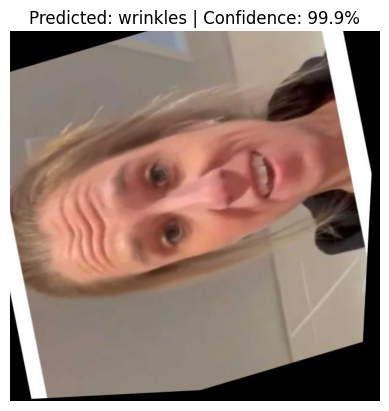

Detected Condition: Wrinkles

Recommended Cosmetic Care Tips:
• Use SPF daily to protect against UV damage.
• Apply moisturizers containing retinol, peptides, or hyaluronic acid.
• Maintain hydration and consistent sleep patterns.


In [18]:
import random

# Pick a random image from the validation dataset
sample = random.choice(val_ds.paths)
img = Image.open(sample).convert("RGB")

# Prepare and predict
x = val_tfms(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    out = model(x)
    pred_idx = out.argmax(1).item()
    pred_label = train_ds.classes[pred_idx]
    confidence = torch.softmax(out, dim=1)[0][pred_idx].item()

# Show the prediction result
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {pred_label} | Confidence: {confidence*100:.1f}%")
plt.show()

# Generate cosmetic advice
skincare_advice(pred_label)
